<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quite Complex Simulation

### Inevitable Imports

In [0]:
import scipy.integrate as integrate
import matplotlib.pyplot as plt

from math import sqrt
import numpy as np

simulatedObjects = []


### Display functions 

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


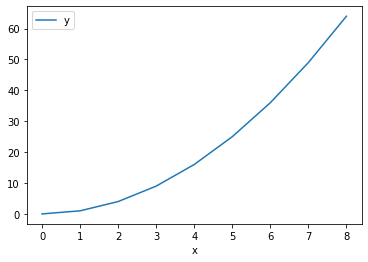

In [31]:
import pandas as pd

def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  #display(df)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
displayData(data)


### Operators on Data Streams

In [32]:
def skip(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    next(innerGen)
  return innerGen

def take(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    yield next(innerGen)

def dilute(generator, ratio):
  innerGen = iter(generator)
  while True:
    skip(innerGen, ratio - 1)
    yield next(innerGen)

#=================#
# example of use  #
#=================#
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
partOfData = take(skip(data, 5), 2) # skip five, take two next, rest blow up
dilutedData = dilute(data, 2) # every odd
displayData(data)
displayData(partOfData)
displayData(dilutedData)


,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


,x,y
0,5,25
1,6,36


,x,y
0,1,1
1,3,9
2,5,25
3,7,49


$\left(\right)$

### Compute One Step function

[{'x': 0.0009999000075938194, 'y': 0.0009998509674025839}, {'x': 0.010998900083532014, 'y': 0.01099296622039253}, {'x': 0.11098890084291396, 'y': 0.11038467664670285}, {'x': 0.7359889008429139, 'y': 0.7094195134137716}, {'x': 1.360988900842914, 'y': 1.2701340376808403}, {'x': 1.985988900842914, 'y': 1.7925282494479091}, {'x': 2.610988900842914, 'y': 2.2766021487149777}, {'x': 3.235988900842914, 'y': 2.7223557354820462}, {'x': 3.860988900842914, 'y': 3.129789009749115}, {'x': 4.485988900842914, 'y': 3.498901971516184}, {'x': 5.110988900842915, 'y': 3.829694620783253}, {'x': 5.735988900842915, 'y': 4.122166957550322}, {'x': 6.360988900842915, 'y': 4.37631898181739}, {'x': 6.985988900842915, 'y': 4.592150693584459}, {'x': 7.610988900842915, 'y': 4.769662092851528}, {'x': 8.235988900842916, 'y': 4.908853179618596}, {'x': 8.860988900842916, 'y': 5.009723953885665}, {'x': 9.485988900842916, 'y': 5.072274415652734}, {'x': 10.110988900842916, 'y': 5.096504564919803}, {'x': 10.735988900842916, 

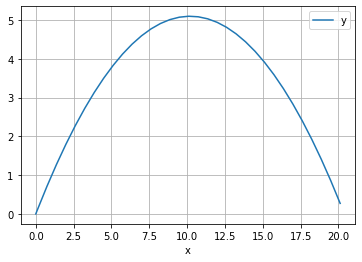

In [37]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    yield currentItem
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

### Prepare and Simulate

In [0]:
def prepareSimulation(systemList, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  for system in systemList:
    system['solver'] = compute(system['model'], system['state0'], t0 = t0, t_bound = t_bound, max_step = max_step)
    system['finished'] = False
    system['result'] = next(system['solver'])#system['state0']

def simulate(systemList):
  for system in systemList:
    if system['finished'] == False:
      system['result'] = next(system['solver'])

### Nearly Infinite Simulation

In [0]:
def simulateInf(systemList, count = -1):
  cc = count
  while True:
    simulate(systemList)
    partialResult = {}
    for system in systemList:
      partialResult[system['name']] = {**system}
    yield partialResult
    cc = cc - 1
    if cc == 0:
      break


### Example of Single System Simulation

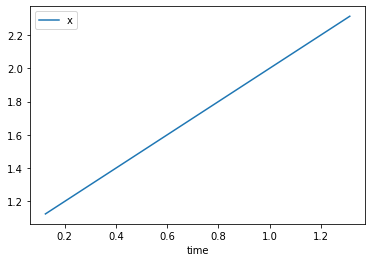

In [41]:
def movingObj(time, state):
  velocity = state[:3]
  position = state[3:]
  acceleration = [0, 0, 0]
  return [*acceleration, *velocity]

def rearangeResults(results, selectors):
  for result in results:
    partialResult = {}
    for selector in selectors:
      partialResult[selector['name']] = selector['selector'](result)
    yield partialResult

simulatedObjects = [{'state0': [1, 0.75, 0, 1, 1, 0], 'model': movingObj, 'name': 'obj1'}]
prepareSimulation(simulatedObjects)
simResults = list(simulateInf(simulatedObjects, 20))
simResultsRearanged = list(rearangeResults(simResults, 
  [
   {'name': 'time', 'selector': lambda item: item['obj1']['result']['time']},
   {'name': 'x', 'selector': lambda item: item['obj1']['result']['y'][3]},
   {'name': 'y', 'selector': lambda item: item['obj1']['result']['y'][4]}
   ]))

#simResults = list(justTwoFromResults(simResults, 'obj1', x = 3, y = 4))

#displayData(simResultsRearanged)
plotData(simResultsRearanged)#, x = 'x', y = 'y')

### More Complex Simulation

#### Plane Model

In [0]:
def createPlaneModel(input):
  def planeModel(time, state):
    currentInput = input()
    
    currentVelocity = np.array([state[0], state[1], state[2]])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array([state[3], state[4], state[5]])
    targetPosition = np.array([currentInput[0], currentInput[1], currentInput[2]])

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs

    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return planeModel

#### Rocket Model

In [0]:
def createRocketModel(rocketSystem, systemToDestroy):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['state']['state']
    #print('currentInput', currentInput)
    currentVelocity = np.array([state[0], state[1], state[2]])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array([state[3], state[4], state[5]])
    targetPosition = np.array([currentInput[0], currentInput[1], currentInput[2]])

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector

    if wantedVelocityAbs < 1e0:
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True

    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return rocketModel


In [0]:
def createFixedTarget(x, y, z):
  def fixedPoint():
    return [x, y, z]
  return fixedPoint

{'plane': {'time': 0.45031802827833756, 'state': [-46.060526303859774, 17.649007344872317, -1.764900734487232, -31.38969909265796, 4.861719584776878, 999.5138280415224], 'stateD': [80.93798204893187, 17.102408311184718, -1.7102408311184714, -46.060526303859774, 17.649007344872317, -1.764900734487232]}, 'rocket': {'time': 0.16998253721160983, 'state': [185.75164668160033, 22.476048138711818, -0.06437738877427082, 536.7645061217675, -497.93927999973783, -0.0051704152792531885], 'stateD': [-325.8919638524057, 101.497189279237, -0.35874988158771026, 185.75164668160033, 22.476048138711818, -0.06437738877427082]}}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: generator 'dilute' raised StopIteration
  


KeyError: ignored

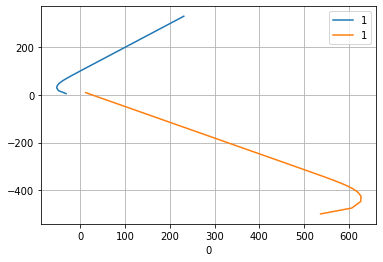

In [0]:
simulatedObjects = []
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1],
    systemToDestroy = lambda : simulatedObjects[0])

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.0625)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))
planeSimResults = list(justTwoFromResults(simResults, 'plane', x = 3, y = 4))
rocketSimResults = list(justTwoFromResults(simResults, 'rocket', x = 3, y = 4))
#displayData(simResults)
ax = plotData(planeSimResults)
ax = plotData(rocketSimResults, ax = ax)
plt.grid(which='both')

print(simResults[0])
ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['state'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['state'][4]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['state'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['state'][4]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  ]

reData = rearangeResults(simResults, ids)
displayData(reData)

### Three System Simulation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: generator 'dilute' raised StopIteration
  from ipykernel import kernelapp as app


,time,plane_x,plane_y,rocket_x,rocket_y,antirocket_x,antirocket_y
0,0.231568,-19.127368,1.542683,546.651526,-497.988955,29.781177,-1.212034
1,0.544068,-35.369312,6.582908,592.374972,-490.549611,102.204320,-13.691572
2,0.856568,-44.650011,12.862027,620.360838,-480.755950,169.029989,-36.239163
3,1.169068,-49.641599,19.244076,636.430408,-470.312102,231.223767,-65.805284
4,1.481568,-51.926075,25.271409,644.414084,-459.974750,289.653754,-100.320075
...,...,...,...,...,...,...,...
95,29.919068,230.341854,327.363330,174.198505,272.576452,174.159915,271.263350
96,30.231568,233.585923,330.575182,174.198505,272.576452,174.159915,271.263350
97,30.544068,236.829991,333.787034,174.198505,272.576452,174.159915,271.263350
98,30.856568,240.074060,336.998886,174.198505,272.576452,174.159915,271.263350


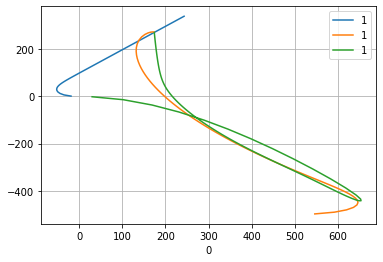

In [0]:
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createModelWithDestination(planeTarget, createPlaneModel())
rocketTarget = lambda : simulatedObjects[0]['state']['state'][3:] 
rocket = createModelWithDestination(rocketTarget, createRocketModel())
antiRocketTarget = lambda : simulatedObjects[1]['state']['state'][3:] 
antiRocket = createModelWithDestination(antiRocketTarget, createRocketModel())

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  {'state0': [250, 0, 0, 0, 0, 0], 'model': antiRocket, 'name': 'antiRocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.03125)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))
planeSimResults = list(justTwoFromResults(simResults, 'plane', x = 3, y = 4))
rocketSimResults = list(justTwoFromResults(simResults, 'rocket', x = 3, y = 4))
antiRocketSimResults = list(justTwoFromResults(simResults, 'antiRocket', x = 3, y = 4))
#displayData(simResults)
ax = plotData(planeSimResults)
ax = plotData(rocketSimResults, ax = ax)
ax = plotData(antiRocketSimResults, ax = ax)
plt.grid(which='both')

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['state'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['state'][4]},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['state'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['state'][4]},
  {'name': 'antirocket_x', 'selector': lambda item: item['antiRocket']['state'][3]},
  {'name': 'antirocket_y', 'selector': lambda item: item['antiRocket']['state'][4]},
  ]

reData = rearangeResults(simResults, ids)
displayData(reData)